## 0. Libraries + meta params

#### Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter

import utils.data_processing as data_processing
import utils.visualize as visualize
import json
import pprint
import os

import torch
import logging

from IPython.display import clear_output
from torchmetrics import ConfusionMatrix
import seaborn as sns

/home/wrongwizzli/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/wrongwizzli/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(filename='execution.log', encoding='utf-8', level=logging.INFO)
logger = logging.getLogger('ExecLog')

In [4]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

'cuda'

In [5]:
config = json.load(open("config.json", "r"))

In [23]:
using_wide_seq = True
if using_wide_seq:
    ACTIVITY_THRESHOLD = 60
    SEQUENCE_LENGTH = 60
else:
    ACTIVITY_THRESHOLD = 30
    SEQUENCE_LENGTH = 30

start_week = "02.07.2017"
start_week = datetime.datetime.strptime(start_week, "%d.%m.%Y")

random_state = np.random.randint(100000)
logger.info("Random state: %d", random_state)

data_path = "./data/daod_mc16_13TeV_sequences.csv"
susy_data_path = "./data/SUSY_mc16_13TeV_popularity.csv"

## 1. Read data

In [24]:
df = pd.read_csv(data_path)
susy_df = pd.read_csv(susy_data_path)
df.head(2)

,datasetname,n_tasks,label
0,mc16_13TeV:mc16_13TeV.300000.Pythia8BPhotospp_...,"{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",0
1,mc16_13TeV:mc16_13TeV.301000.PowhegPythia8EvtG...,"{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",0


In [25]:
susy_df.head(2)

,datasetname,n_tasks,label
0,mc16_13TeV:mc16_13TeV.301000.PowhegPythia8EvtG...,"{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",0
1,mc16_13TeV:mc16_13TeV.301000.PowhegPythia8EvtG...,"{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...",0


In [26]:
def retrieve_sequence_from_string(n_tasks: str):
    str_values = n_tasks[1:-1].split(',')
    return [int(str_value) for str_value in str_values]


list_sequences = df['n_tasks'].apply(retrieve_sequence_from_string).to_list()
dataset_names = df['datasetname'].to_numpy()
numpy_sequences = np.array(list_sequences)

In [27]:
susy_list_sequences = susy_df['n_tasks'].apply(retrieve_sequence_from_string).to_list()
susy_dataset_names = susy_df['datasetname'].to_numpy()
susy_numpy_sequences = np.array(susy_list_sequences)

## 2. Preprocessing

In [28]:
active_datasets = numpy_sequences[numpy_sequences.sum(axis=1) > ACTIVITY_THRESHOLD]
active_names = dataset_names[numpy_sequences.sum(axis=1) > ACTIVITY_THRESHOLD]

susy_active_datasets = susy_numpy_sequences[susy_numpy_sequences.sum(axis=1) > ACTIVITY_THRESHOLD]
susy_active_names = susy_dataset_names[susy_numpy_sequences.sum(axis=1) > ACTIVITY_THRESHOLD]

active_datasets.shape, active_names.shape, susy_active_datasets.shape, susy_active_names.shape

((3885, 305), (3885,), (6603, 319), (6603,))

In [29]:
train_data, test_data = train_test_split(active_datasets, test_size=0.15)
train_data.shape, test_data.shape

((3302, 305), (583, 305))

#### Count each week proportion of 0/1

In [30]:
# Count full zero sequences of each week
is_full_zeros = np.zeros(active_datasets.shape)
for i in tqdm(range(is_full_zeros.shape[0])):
    for j in range(is_full_zeros.shape[1]):
        left_idx = max(0, j - SEQUENCE_LENGTH - 1)
        is_full_zeros[i, j] = (active_datasets[i, left_idx : (j + 1)].sum() == 0)
        
full_zeros_by_week = is_full_zeros.sum(axis=0)
accesses_by_week = (active_datasets > 0).sum(axis=0)

100%|██████████| 3885/3885 [00:02<00:00, 1661.83it/s]


<BarContainer object of 305 artists>

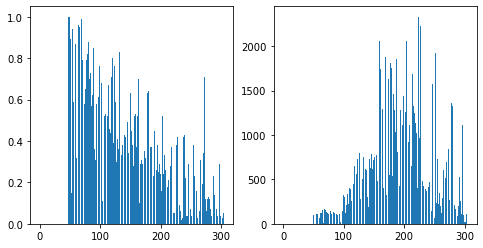

In [31]:
accesses_by_week_freq = accesses_by_week / (active_datasets.shape[0] - full_zeros_by_week + 1e-8)
accesses_by_week_freq = np.round(accesses_by_week_freq, 2)
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(8)
ax[0].bar(np.arange(accesses_by_week_freq.shape[0]), accesses_by_week_freq)
ax[1].bar(np.arange(accesses_by_week_freq.shape[0]), accesses_by_week)

In [32]:
# Describes the proportions of 0/1 labels for each week (we are excluding full zero pre-week sequences when counting proportion)
# Only zeros sequence is obviously 0 next week)
weeks_by_balance = {}
step = 0.1
for balance_prop in np.arange(0, 1, step):
    weeks = np.nonzero(
        ((accesses_by_week_freq > balance_prop) & (accesses_by_week_freq <= balance_prop + step))
    )[0]
    weeks_by_balance[f'{int(balance_prop * 100)}-{int(balance_prop * 100) + 10}'] = weeks.tolist()
json.dump(weeks_by_balance, open('dumps/weeks_by_balance.json', 'w'), indent=1)
weeks_by_balance.keys()

dict_keys(['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])

In [33]:
optimal_weeks = weeks_by_balance['40-50']
np.array(optimal_weeks)

array([ 60, 105, 108, 115, 117, 129, 131, 136, 138, 140, 142, 144, 145,
       148, 152, 164, 182, 190, 199, 228, 238, 239, 296])

##### Get dataset

In [34]:
# Get sequence for certain week by id. Or randomly retrieve any week data
def get_week_by_id(data, week_id):
    non_zero_idcs = []
    left_idx = week_id - SEQUENCE_LENGTH
    logger.info('week_id: %d', week_id)
    if left_idx < 0:
        logger.warning(f"week_id is too low. First train week will be with id 0.")
    if week_id >= data.shape[1]:
        logger.warning(f"week_id is bigger than the maximum value!")
        return None
    for i in range(data.shape[0]):
        if data[i, left_idx : (week_id + 1)].sum() > 0:
            non_zero_idcs.append(i)
    return data[non_zero_idcs, left_idx:week_id + 1], week_id

def get_random_week_by_key(weeks_by_balance: dict, data, key=None):
    if key is None:
        key = np.random.choice(list(weeks_by_balance.keys()))
        logger.info(f"No proportion key is provided. Randomly selected: {key}")
    return get_week_by_id(data, np.random.choice(weeks_by_balance[key]))

In [35]:
week_id = 147
dataset, week_id = get_week_by_id(active_datasets, week_id)
train_data, test_data = train_test_split(dataset, test_size=0.15, random_state=random_state)
train_data.shape, test_data.shape

((1181, 61), (209, 61))

In [60]:
print(f"""
Sequence length: {SEQUENCE_LENGTH},
Size of Train subset: {train_data.shape[0]},
Size of Test subset: {test_data.shape[0]},
Train balance (% of ones): {np.round((train_data[:, -1] > 0).sum() / train_data.shape[0], 2)},
Test balance (% of ones): {np.round((test_data[:, -1] > 0).sum() / test_data.shape[0], 2)}.
""")


Sequence length: 60,
Size of Train subset: 1181,
Size of Test subset: 209,
Train balance (% of ones): 0.33,
Test balance (% of ones): 0.4.



##### Visualize samples

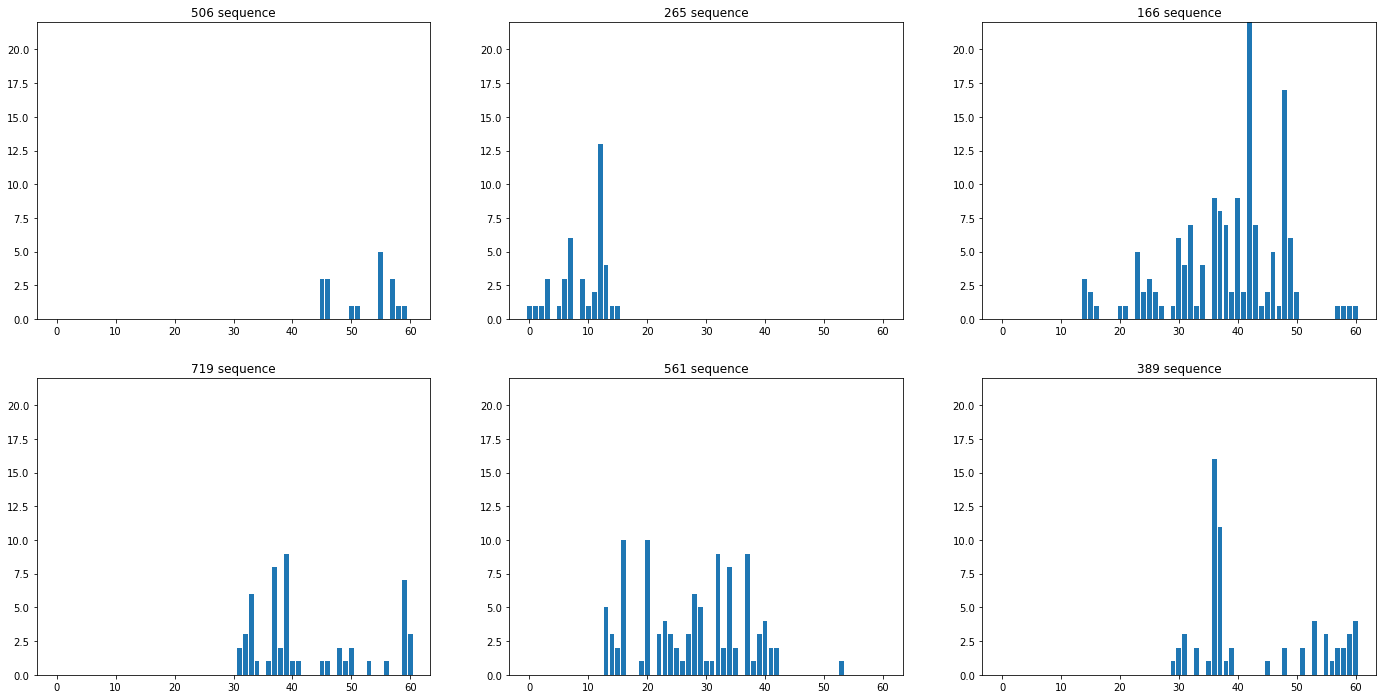

In [61]:
_ = visualize.visualize_random_sequences(train_data, 2, 3)
plt.savefig("examples.png", dpi=200, bbox_inches='tight')

## 3. Models

### Raw FCN

In [62]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self , tensors):
        super(CustomDataset, self).__init__()
        self.tensors = tensors

    def __getitem__(self, index):
        x = self.tensors[0][index]  
        y = self.tensors[1][index]    
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.tensors[0])

In [63]:
class SimpleFCN(torch.nn.Module):
    def __init__(self):
        super(SimpleFCN, self).__init__()
        self.fcn = torch.nn.Sequential(
            torch.nn.Conv1d(1, 16, 17, padding="same"),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(16),
            torch.nn.Conv1d(16, 32, 13),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(32),
            torch.nn.Conv1d(32, 64, 9),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, 5),
            torch.nn.BatchNorm1d(128),
            torch.nn.AdaptiveAvgPool1d(2),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 2)
        )
    def forward(self, X):
        return self.fcn(X)

#### No balance

In [64]:
model = SimpleFCN()
model = model.to(device)

In [65]:
def train_model(model, epochs, optima, crit, train_loader, val_loader):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    confmat = ConfusionMatrix(num_classes=2, task="binary").to(device)
    for i in tqdm(range(epochs)):
        batch_train_losses = []
        batch_train_acc = []
        train_confusion_matrix = torch.zeros((2, 2)).long().to(device)
        for X, y in train_loader:
            
            optima.zero_grad()
            
            y_pred = model(X)
            loss = crit(y_pred, y)
            y_act = torch.nn.Sigmoid()(y_pred)
            train_confusion_matrix += confmat(y_act, y)
            batch_train_acc.append(((y_act.argmax(axis=1) == y).sum() / y.shape[0]).item())
            loss.backward()
            batch_train_losses.append(loss.item())
            
            optima.step()
        batch_val_losses = []
        batch_val_acc = []
        val_confusion_matrix = torch.zeros((2, 2)).long().to(device)
        with torch.no_grad():
            for X, y in val_loader:
                y_pred = model(X)
                loss = crit(y_pred, y)
                y_act = torch.nn.Sigmoid()(y_pred)
                val_confusion_matrix += confmat(y_act, y)
                batch_val_acc.append(((y_act.argmax(axis=1) == y).sum() / y.shape[0]).item())
                batch_val_losses.append(loss.item())
        train_accuracies.append(np.mean(batch_train_acc))
        train_losses.append(np.mean(batch_train_losses))
        val_accuracies.append(np.mean(batch_val_acc))
        val_losses.append(np.mean(batch_val_losses))
        clear_output()
        fig, ax = plt.subplots(ncols=2)
        fig.set_figheight(8)
        fig.set_figwidth(16)
        ax[0].plot(np.arange(len(train_losses)), train_losses)
        ax[0].plot(np.arange(len(val_losses)), val_losses)
        ax[0].legend(['train_loss', 'val_loss'])
        ax[1].plot(np.arange(len(train_accuracies)), train_accuracies)
        ax[1].plot(np.arange(len(val_accuracies)), val_accuracies)
        ax[1].legend(['train_accuracy', 'val_accurracy'])
        plt.show()
        sns.heatmap(val_confusion_matrix.to('cpu').numpy(), annot=True)
        plt.show()
    return train_losses, val_losses
    

In [66]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.CrossEntropyLoss()

In [68]:
X_train = torch.from_numpy(train_data[:, :-1]).float().reshape(train_data.shape[0], 1, train_data.shape[1] - 1)
y_train = torch.from_numpy(train_data[:, -1] > 0).long()
X_val = torch.from_numpy(test_data[:, :-1]).float().reshape(test_data.shape[0], 1, test_data.shape[1] - 1)
y_val = torch.from_numpy(test_data[:, -1] > 0).long()

In [69]:
train_dataset = CustomDataset((X_train, y_train))
val_dataset = CustomDataset((X_val, y_val))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

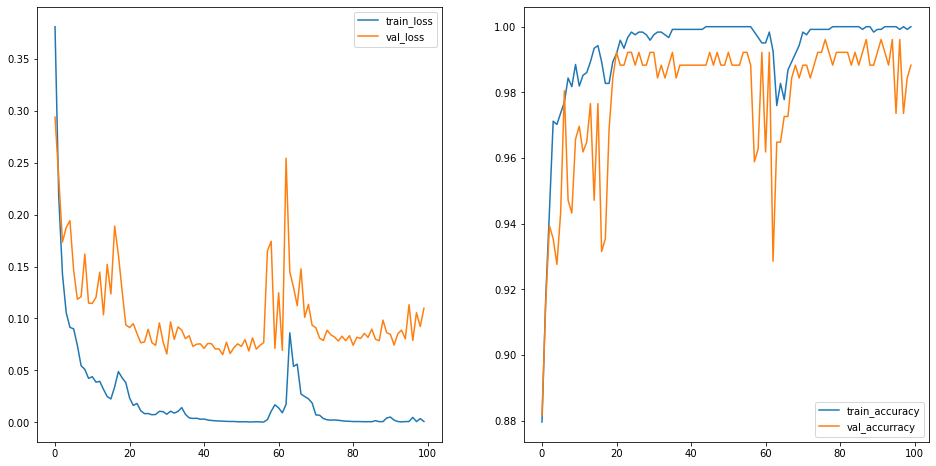

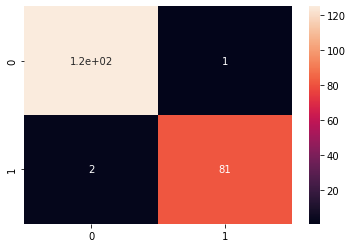

100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


In [70]:
_ = train_model(model, 100, optimizer, loss, train_loader, val_loader)

In [80]:
dataset, week_id = get_week_by_id(active_datasets, week_id + 1)
Xy_train, Xy_test = train_test_split(dataset, test_size=0.15, random_state=random_state)
X_true_test0 = np.concatenate((Xy_train, Xy_test))
X_test = torch.FloatTensor(X_true_test0[:, :-1]).to(device)
y_test = torch.LongTensor(X_true_test0[:, -1] > 0).to(device)

In [81]:
preds = []
trues = []
matrix = torch.zeros((2, 2)).to(device)
confmat = ConfusionMatrix(num_classes=2, task="binary").to(device)
ypreds = torch.argmax(torch.sigmoid(model(X_test.reshape(X_test.shape[0], 1, X_test.shape[1]))), axis=1)
matrix += confmat(ypreds, y_test)
matrix

tensor([[667., 110.],
        [252., 362.]], device='cuda:0')

In [82]:
accuracy = ((matrix[0, 0] + matrix[1, 1]) / matrix.sum()).item()
precision_1 = (matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])).item()
recall_1 = (matrix[0, 0] / (matrix[0, 0] + matrix[1, 0])).item()
precision_0 = (matrix[1, 1] / (matrix[1, 1] + matrix[1, 0])).item()
recall_0 = (matrix[1, 1] / (matrix[1, 1] + matrix[0, 1])).item()
f1_score_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)
f1_score_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)
print(f"""Overall metrics:
Accuracy      : {np.round(accuracy, 3)}
Precision on 1: {np.round(precision_1, 3)}
Recall on 1   : {np.round(recall_1, 3)}
F-score on 1  : {np.round(f1_score_1, 3)}
Precision on 0: {np.round(precision_0, 3)}
Recall on 0   : {np.round(recall_0, 3)}
F-score on 0  : {np.round(f1_score_0, 3)}
""")

Overall metrics:
Accuracy      : 0.74
Precision on 1: 0.858
Recall on 1   : 0.726
F-score on 1  : 0.787
Precision on 0: 0.59
Recall on 0   : 0.767
F-score on 0  : 0.667



### Logistic Regression

In [102]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [103]:
dataset, week_id = get_week_by_id(active_datasets, 100)
train_data, test_data = train_test_split(dataset, test_size=0.15, random_state=random_state)
train_data.shape, test_data.shape

((360, 61), (64, 61))

In [104]:
X_train, y_train = train_data[:, :-1], train_data[:, -1]
X_test, y_test = test_data[:, :-1], test_data[:, -1]

In [142]:
results = {}
for i in tqdm(range(100)):
    while True:
        try:
            dataset, week_id = get_random_week_by_key(weeks_by_balance, active_datasets)
            if (not week_id in list(results.keys())) and dataset.shape[0] > 0 and (dataset[:, -1] > 0).sum() * 2.5 > dataset.shape[0]:
                break
        except Exception as e:
            pass
    train_data, test_data = train_test_split(dataset, test_size=0.15, random_state=random_state)
    X_train, y_train = train_data[:, :-1], train_data[:, -1]
    X_test, y_test = test_data[:, :-1], test_data[:, -1]
    
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, (y_train > 0).astype(int))
    
    preds = clf.predict(X_test)
    matrix = confusion_matrix(y_test > 0, preds)
    if matrix.shape[0] > 1:
        accuracy = ((matrix[0, 0] + matrix[1, 1]) / matrix.sum())
        precision_1 = (matrix[0, 0] / (matrix[0, 0] + matrix[0, 1]))
        recall_1 = (matrix[0, 0] / (matrix[0, 0] + matrix[1, 0]))
        precision_0 = (matrix[1, 1] / (matrix[1, 1] + matrix[1, 0]))
        recall_0 = (matrix[1, 1] / (matrix[1, 1] + matrix[0, 1]))
        f1_score_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)
        f1_score_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)
        results[week_id] = (accuracy, precision_1, recall_1, precision_0, recall_0, f1_score_1, f1_score_0)

100%|██████████| 100/100 [00:05<00:00, 18.04it/s]


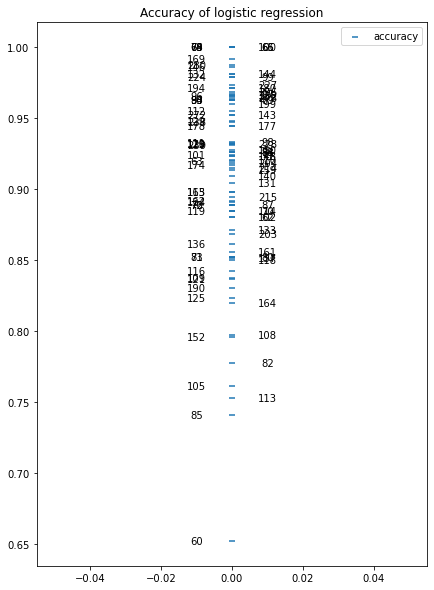

In [143]:
plt.figure(figsize=(7, 10))
plt.scatter([0] * len(results), [results[key][0] for key in results.keys()], marker="_")
plt.title("Accuracy of logistic regression")
plt.legend(['accuracy'])
for i, key in enumerate(results.keys()):
    plt.text(0.01 * (2 * (i % 2) - 1), results[key][0], f"{key}", ha='center', va='center')

### Clustering

#### DBSCAN

In [40]:
from sklearn.cluster import DBSCAN

In [137]:
for i in range(active_datasets.shape[1]):
    if active_datasets[:, i].sum() > 0:
        break
first_week_idx = i
print("First active week:", i)

First active week: 48


In [138]:
data_cut = active_datasets[:, first_week_idx:]
data_cut.shape

(3885, 257)

In [139]:
clf = DBSCAN(eps=13, min_samples=15)
preds = clf.fit_predict(data_cut)
appearances = {}
for idx in np.unique(preds):
    appearances[idx] = (preds == idx).sum()
appearances

{-1: 467, 0: 70, 1: 358, 2: 65, 3: 1874, 4: 595, 5: 46, 6: 34, 7: 300, 8: 76}

In [142]:
names_splitted = []
for name in active_names:
    name = name.split(':')[-1].split('.')
    names_splitted.append(name)
names_splitted = np.array(names_splitted)
names_splitted[0]

array(['mc16_13TeV', '301899', 'Sherpa_CT10_eegammaPt35_70', 'deriv',
       'DAOD_HIGG2D1', 'e3952_s3126_r9364_r9315_p3387_tid12642379_00'],
      dtype='<U60')

In [143]:
diff_count = []
for idx in np.unique(preds):
    class_names = names_splitted[preds == idx]
    diff_count.append([np.unique(class_names[:, i]).shape[0] for i in range(class_names.shape[1])] + [class_names.shape[1]])
diff_count

[[1, 107, 107, 1, 9, 467, 6],
 [1, 41, 41, 1, 1, 70, 6],
 [1, 78, 77, 1, 1, 358, 6],
 [1, 27, 26, 1, 1, 65, 6],
 [1, 169, 169, 1, 3, 1874, 6],
 [1, 126, 126, 1, 3, 595, 6],
 [1, 12, 12, 1, 1, 46, 6],
 [1, 18, 18, 1, 1, 34, 6],
 [1, 48, 48, 1, 1, 300, 6],
 [1, 38, 38, 1, 1, 76, 6]]

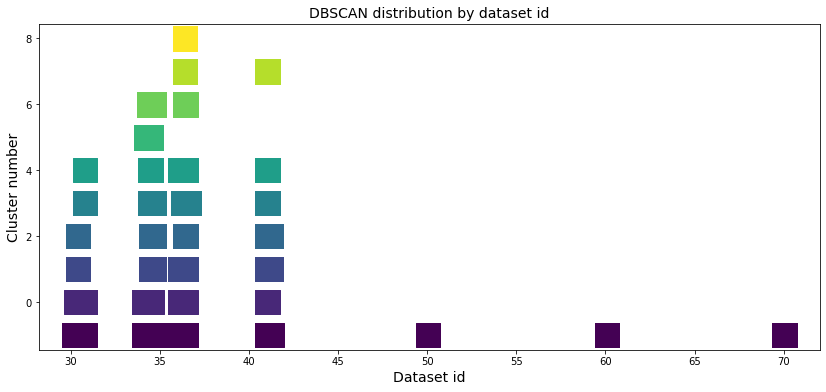

In [155]:
# Dataset ids
dataset_id = names_splitted[:, 1].astype(int)
plt.figure(figsize=(14, 6))
plt.scatter(dataset_id / 10000, preds, c=preds, marker=',', s=600)
plt.title("DBSCAN distribution by dataset id", fontsize=14)
plt.ylabel("Cluster number", fontsize=14)
_ = plt.xlabel("Dataset id", fontsize=14)

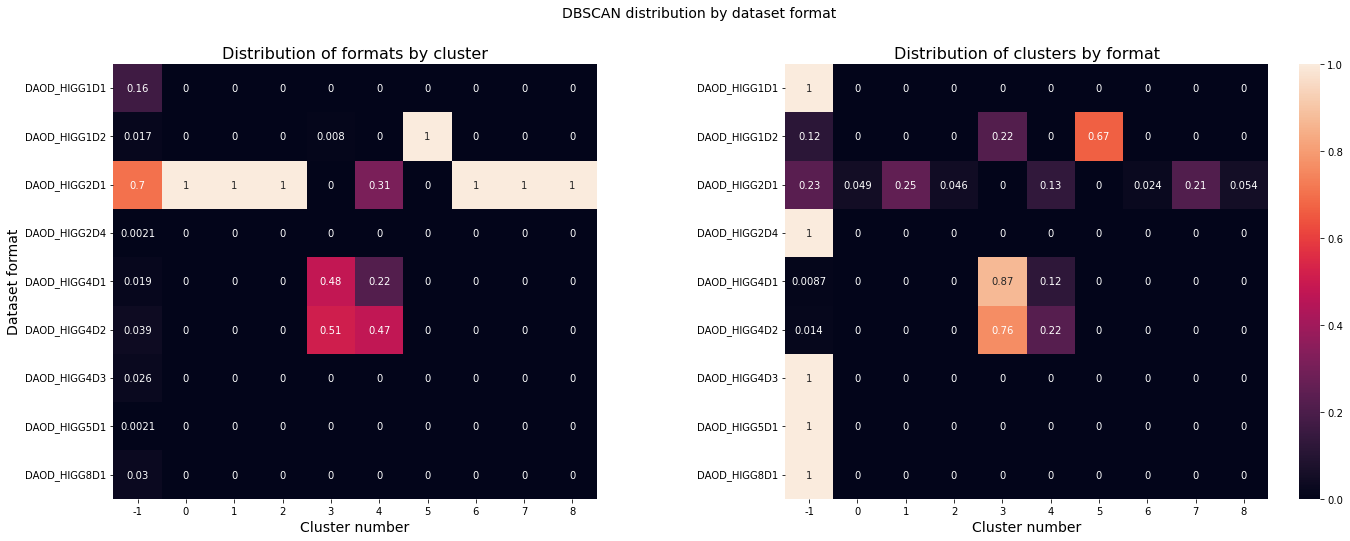

In [252]:
# Dataset format
dataset_format = names_splitted[:, 4]

unique_formats = np.unique(dataset_format)
unique_clusters = np.sort(np.unique(preds))

heatmap_by_cluster = np.zeros((unique_formats.shape[0], unique_clusters.shape[0]))
for cluster_id in unique_clusters:
    cluster_formats = dataset_format[preds == cluster_id]
    for format_id, format in enumerate(unique_formats):
        heatmap_by_cluster[format_id, cluster_id - unique_clusters[0]] = (cluster_formats == format).sum() / cluster_formats.shape[0]

heatmap_by_format = np.zeros((unique_formats.shape[0], unique_clusters.shape[0]))
for format_id, format in enumerate(unique_formats):
    clusters = preds[dataset_format == format]
    cnt = Counter(clusters)
    for cluster_id in unique_clusters:
        heatmap_by_format[format_id, cluster_id - unique_clusters[0]] = cnt[cluster_id] / clusters.shape[0]
fig, ax = plt.subplots(ncols=2, figsize=(24, 8))
sns.heatmap(heatmap_by_cluster, annot=True, yticklabels=unique_formats, xticklabels=unique_clusters, ax=ax[0], cbar=False, square=True, vmax=1)
sns.heatmap(heatmap_by_format, annot=True, yticklabels=unique_formats, xticklabels=unique_clusters, ax=ax[1], cbar=True, square=True, vmax=1)
plt.suptitle("DBSCAN distribution by dataset format", fontsize=14)
ax[0].set_ylabel("Dataset format", fontsize=14)
ax[0].set_xlabel("Cluster number", fontsize=14)
ax[1].set_xlabel("Cluster number", fontsize=14)
ax[0].set_title("Distribution of formats by cluster", fontsize=16)
_ = ax[1].set_title("Distribution of clusters by format", fontsize=16)

In [223]:
# Dataset filter
filter_frequency = {}
splitted_data = []
splitted_preds = []
dataset_filter = names_splitted[:, 2]
for i, sample in enumerate(dataset_filter):
    for filter in sample.split("_"):
        if filter not in filter_frequency:
            filter_frequency[filter] = 0
        filter_frequency[filter] += 1
        splitted_data.append(filter)
        splitted_preds.append(preds[i])
filter_frequency = dict(sorted(filter_frequency.items(), key=lambda item: item[1]))
top100_filters = list(filter_frequency.keys())[-100:]
splitted_data2 = []
splitted_preds2 = []
for x, y in zip(splitted_data, splitted_preds):
    if x in top100_filters:
        splitted_data2.append(x)
        splitted_preds2.append(y)
splitted_data2 = np.array(splitted_data2)
splitted_preds2 = np.array(splitted_preds2)

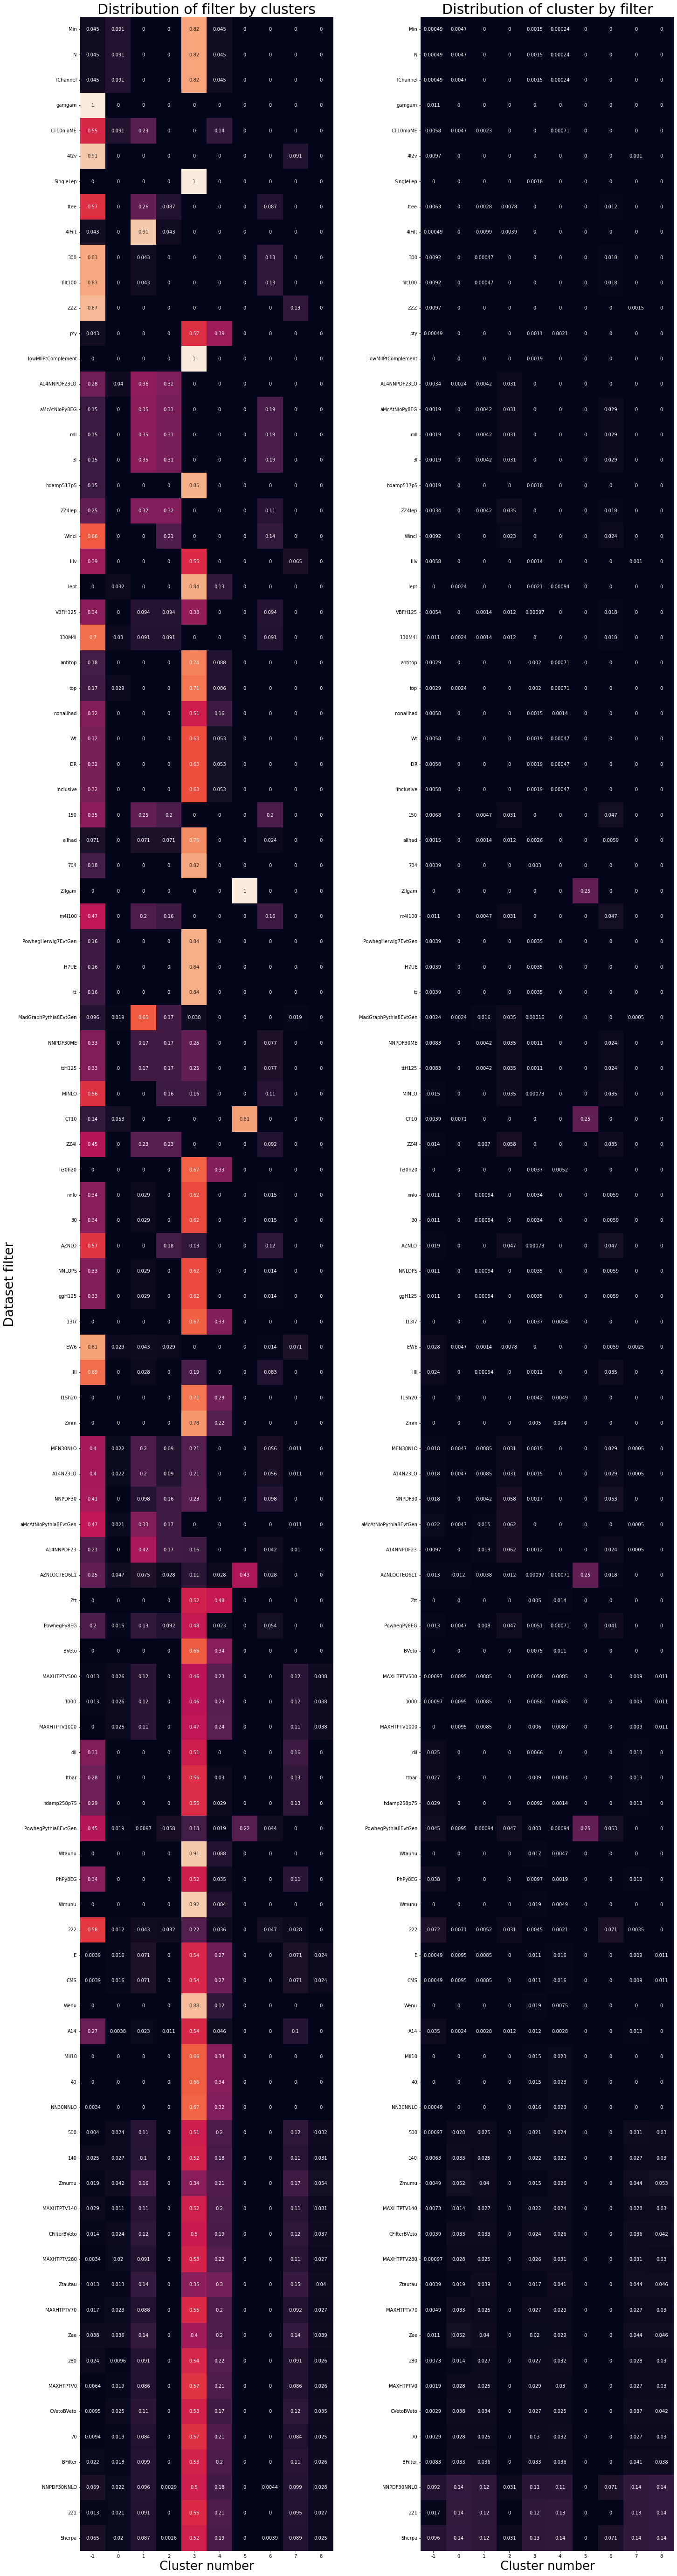

In [251]:
# plt.scatter(splitted_data2, splitted_preds2, c=splitted_preds2, marker=',')
unique_clusters = np.unique(splitted_preds2)
heatmap_by_filter = np.zeros((unique_clusters.shape[0], len(top100_filters)))
for filter_id, filter in enumerate(top100_filters):
    clusters = splitted_preds2[splitted_data2 == filter]
    cnt = Counter(clusters)
    for cluster_id in unique_clusters:
        heatmap_by_filter[cluster_id - unique_clusters[0], filter_id] = cnt[cluster_id] / clusters.shape[0]

heatmap_by_cluster = np.zeros((unique_clusters.shape[0], len(top100_filters)))
for cluster_id in unique_clusters:
    cluster_filters = splitted_data2[splitted_preds2 == cluster_id]
    for filter_id, filter in enumerate(top100_filters):
        heatmap_by_cluster[cluster_id - unique_clusters[0], filter_id] = (cluster_filters == filter).sum() / cluster_filters.shape[0]
fig, ax = plt.subplots(ncols=2, figsize=(24, 100))
sns.heatmap(heatmap_by_filter.T, annot=True, xticklabels=unique_clusters, yticklabels=top100_filters, ax=ax[0], cbar=False, square=True, vmax=1)
sns.heatmap(heatmap_by_cluster.T, annot=True, xticklabels=unique_clusters, yticklabels=top100_filters, ax=ax[1], cbar=False, square=True, vmax=1)
ax[0].set_ylabel("Dataset filter", fontsize=28)
ax[0].set_xlabel("Cluster number", fontsize=26)
ax[1].set_xlabel("Cluster number", fontsize=26)
ax[0].set_title("Distribution of filter by clusters", fontsize=30)
_ = ax[1].set_title("Distribution of cluster by filter", fontsize=30)

##### Susy vs DAOD

In [37]:
for i in range(active_datasets.shape[1]):
    if active_datasets[:, i].sum() > 0:
        break
first_week_idx = i
print("First active week:", i)

for j in range(susy_active_datasets.shape[1]):
    if susy_active_datasets[:, j].sum() > 0:
        break
print("First active week:", j)

First active week: 48
First active week: 50


In [38]:
data_cut = active_datasets[:, first_week_idx:]
susy_data_cut = susy_active_datasets[:, first_week_idx:active_datasets.shape[1]]
data = np.concatenate((data_cut, susy_data_cut))
data_cut.shape, susy_data_cut.shape, data.shape

((3885, 255), (6603, 255), (10488, 255))

100%|██████████| 16/16 [00:17<00:00,  1.09s/it]


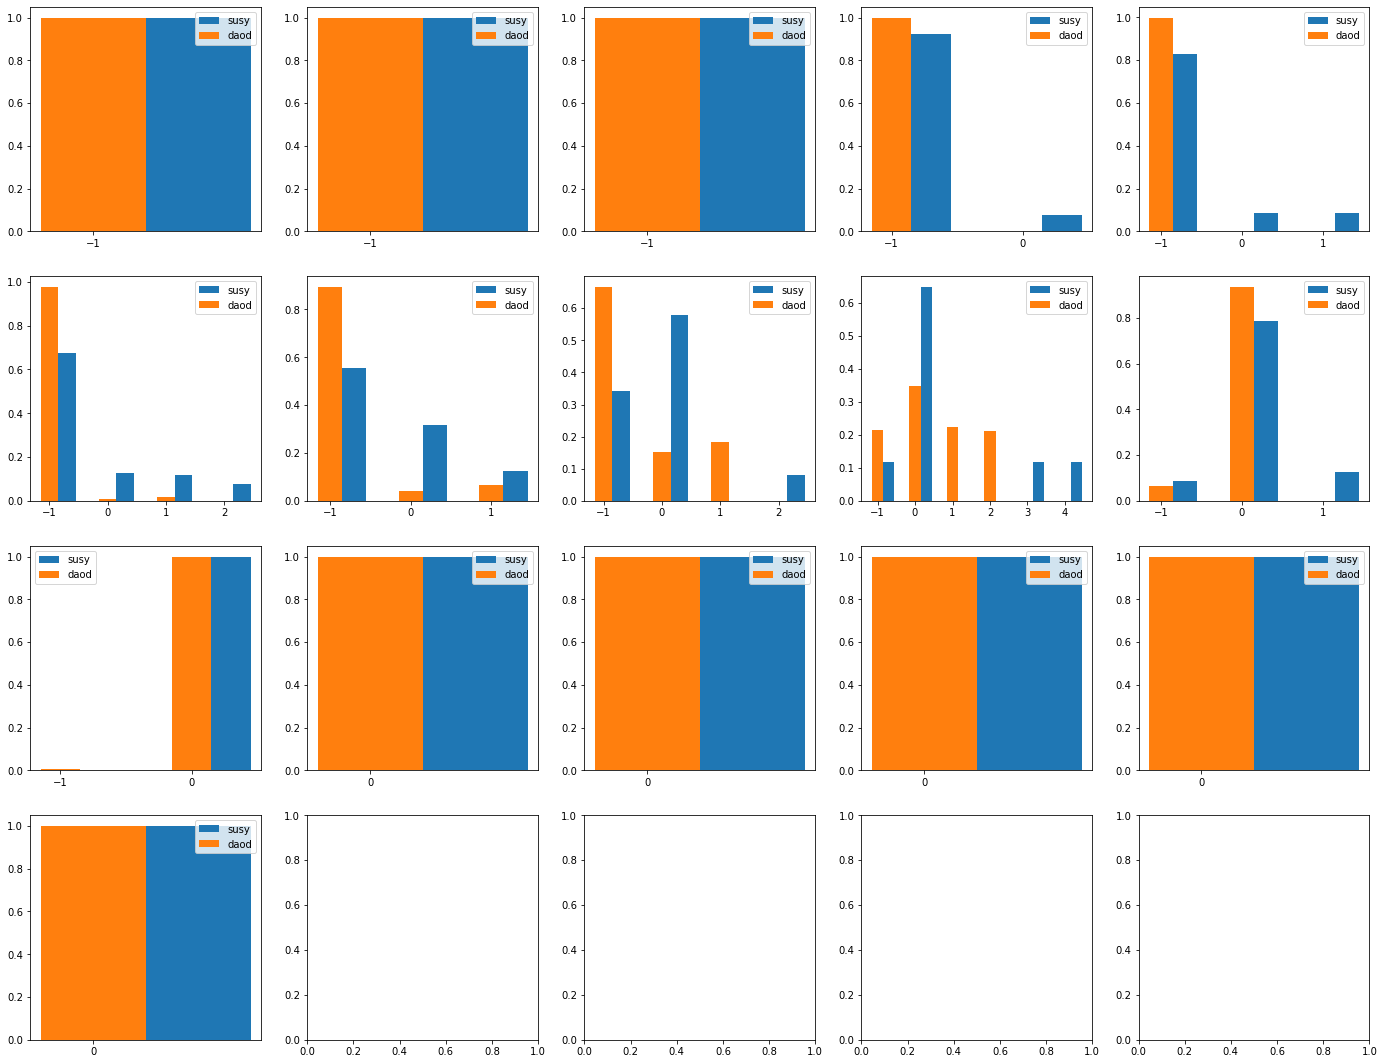

In [100]:
epses = np.arange(1, 9, 0.5)
ncols = 5
nrows = epses.shape[0] // ncols + (epses[0] % ncols > 0)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(24, 24 * nrows // ncols))

for i, eps in enumerate(tqdm(epses)):
    clf = DBSCAN(eps=eps, min_samples=500)
    preds = clf.fit_predict(data > 0)
    appearances = {}
    for idx in np.unique(preds):
        appearances[idx] = (preds == idx).sum()
    unique_preds = np.sort(np.unique(preds))
    x = []
    daod = []
    susy = []
    for pred in unique_preds:
        x.append(pred)
        idcs = np.argwhere(preds == pred)
        daod_part = (idcs < data_cut.shape[0]).sum() / data_cut.shape[0]
        daod.append(daod_part)
        susy_part = (idcs >= data_cut.shape[0]).sum() / susy_data_cut.shape[0]
        susy.append(susy_part)
    x = np.asarray(x)
    ax[i // ncols, i % ncols].bar(x + 0.3, susy, width=0.3)
    ax[i // ncols, i % ncols].bar(x, daod, width=0.3)
    ax[i // ncols, i % ncols].legend(['susy', 'daod'])
    ax[i // ncols, i % ncols].set_xticks(unique_preds)

In [59]:
clf = DBSCAN(eps=21, min_samples=500)
preds = clf.fit_predict(data)
appearances = {}
for idx in np.unique(preds):
    appearances[idx] = (preds == idx).sum()
appearances

{-1: 3403, 0: 7085}

In [67]:
unique_preds = np.sort(np.unique(preds))
unique_preds

array([-1,  0])

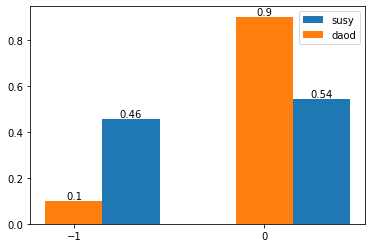

In [84]:
x = []
daod = []
susy = []
for pred in unique_preds:
    x.append(pred)
    idcs = np.argwhere(preds == pred)
    daod_part = (idcs < data_cut.shape[0]).sum() / data_cut.shape[0]
    daod.append(daod_part)
    susy_part = (idcs >= data_cut.shape[0]).sum() / susy_data_cut.shape[0]
    susy.append(susy_part)
x = np.asarray(x)
plt.bar(x + 0.3, susy, width=0.3)
plt.bar(x, daod, width=0.3)
for i, (val_susy, val_daod) in enumerate(zip(susy, daod)):
    plt.text(x[i], val_daod, f"{np.round(val_daod, 2)}", ha='center', va='bottom')
    plt.text(x[i] + 0.3, val_susy, f"{np.round(val_susy, 2)}", ha='center', va='bottom')
plt.legend(['susy', 'daod'])
_ = plt.xticks(unique_preds)